# Clustering Netflix's Film Ratings

In [1]:
import pandas as pd
import numpy as np
import os
import re
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import scipy
import pylab
import sklearn
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_samples, silhouette_score
import random
import matplotlib.cm as cm

## Table of Contents
* 1. Data
* 2. Data Properties
* 3. Hierarchical Clustering Application
* 4. Conclusions

## 1. Data

In [2]:
header = open( os.path.realpath("data/titles.txt"), "r" )
film_titles = []
for i in header:
    film_titles.append( re.split( "\n", re.split( ",", i )[1] )[0] )
header.close()

len( film_titles )

100

In [3]:
#ratings
ratings = np.loadtxt( os.path.realpath("data/ratings.dat") )
ratings.shape

(5000, 100)

Shapes of ratings and film title data do match.

In [4]:
film_data = pd.DataFrame( ratings )
film_data.columns = film_titles
film_data

,Miss Congeniality,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,...,Something's Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4.0,4.0,5.0,4.0,5.0,3.0,5.0,5.0,5.0,4.0,...,4.0,5.0,3.0,3.0,3.0,0.0,5.0,2.0,5.0,5.0
1,4.0,4.0,5.0,4.0,5.0,4.0,5.0,5.0,2.0,5.0,...,4.0,0.0,3.0,0.0,0.0,3.0,3.0,0.0,1.0,0.0
2,3.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,3.0,3.0,...,5.0,0.0,2.0,2.0,3.0,4.0,4.0,5.0,0.0,4.0
3,3.0,4.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0,...,3.0,4.0,3.0,0.0,0.0,4.0,1.0,3.0,0.0,4.0
4,5.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0,5.0,...,4.0,4.0,4.0,3.0,3.0,5.0,3.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,2.0,3.0,...,4.0,5.0,3.0,0.0,4.0,0.0,3.0,4.0,0.0,0.0
4996,2.0,4.0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,4.0,...,0.0,5.0,0.0,5.0,0.0,0.0,4.0,4.0,5.0,0.0
4997,1.0,3.0,4.0,4.0,3.0,2.0,5.0,5.0,3.0,4.0,...,0.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0
4998,1.0,4.0,1.0,4.0,5.0,3.0,4.0,3.0,1.0,1.0,...,0.0,3.0,0.0,0.0,4.0,4.0,1.0,3.0,4.0,4.0


## 2. Data Properties

Some films have minimum rating values of 0, which represents a non-existent review by user represented in row number. Such rows must be eliminated before clustering.

In [5]:
film_data.describe()

,Miss Congeniality,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,...,Something's Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3.620400,4.160400,4.122800,3.709800,4.34960,4.085200,4.520000,4.458000,3.75140,3.768600,...,2.935000,3.840400,2.649800,1.70220,2.436400,3.101800,2.792000,2.540800,1.752600,2.873600
std,0.959004,0.798749,0.890325,0.963208,0.80219,0.875725,0.715893,0.746155,0.88688,0.905769,...,1.799506,1.786272,1.538192,1.80049,1.990766,1.831859,1.651691,1.783864,1.813188,2.157256
min,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,4.000000,3.000000,4.00000,4.000000,4.000000,4.000000,3.00000,3.000000,...,2.000000,4.000000,2.000000,0.00000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,4.000000,4.000000,5.00000,4.000000,5.000000,5.000000,4.00000,4.000000,...,4.000000,5.000000,3.000000,1.00000,3.000000,4.000000,3.000000,3.000000,1.000000,4.000000
75%,4.000000,5.000000,5.000000,4.000000,5.00000,5.000000,5.000000,5.000000,4.00000,4.000000,...,4.000000,5.000000,4.000000,3.00000,4.000000,5.000000,4.000000,4.000000,3.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,5.000000,...,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


One way of eliminating empty reviews is eliminating the whole row competely. According to the code below, roughly every user has at least one zero review of the given films. Therefore, eliminating users with zero entries is infeasible

In [6]:
# too many rows contain null values, eliminating such is infeasible
null_index = np.array( [False] * film_data.shape[0] )
for i in range( film_data.shape[1] ):
    null_index[ film_data.iloc[:,i] == 0 ] = [True] * len([ film_data.iloc[:,i] == 0 ])
sum(null_index)

4935

In order to preserve maximum amount of data, each zero entry under a film is replaced by the zero-excluded mean rating of the film.

In [7]:
for i in range( film_data.shape[1] ):
    film_data.iloc[:,i][ film_data.iloc[:,i] == 0 ] = np.mean( film_data.iloc[:,i][ film_data.iloc[:,i] != 0 ] )

Effect of the previous operation is validated.

In [8]:
sum( film_data.describe().loc["min",:] < 0.5 ) 

0

Hence, mean rating of the films which possess zero rating values has increased.

In [9]:
film_data.describe()

,Miss Congeniality,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,...,Something's Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3.620400,4.160400,4.122800,3.709800,4.34960,4.085200,4.520000,4.458000,3.75140,3.768600,...,3.835599,4.578445,3.255283,3.228756,3.720831,3.925335,3.456301,3.544643,3.093187,4.322503
std,0.959004,0.798749,0.890325,0.963208,0.80219,0.875725,0.715893,0.746155,0.88688,0.905769,...,0.770998,0.596498,0.872528,0.801711,0.912762,0.894849,0.934335,0.794417,0.968332,0.699538
min,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,4.000000,4.000000,3.000000,4.00000,4.000000,4.000000,4.000000,3.00000,3.000000,...,3.000000,4.000000,3.000000,3.000000,3.720831,3.925335,3.000000,3.000000,3.000000,4.000000
50%,4.000000,4.000000,4.000000,4.000000,5.00000,4.000000,5.000000,5.000000,4.00000,4.000000,...,4.000000,5.000000,3.255283,3.228756,3.720831,4.000000,3.456301,3.544643,3.093187,4.322503
75%,4.000000,5.000000,5.000000,4.000000,5.00000,5.000000,5.000000,5.000000,4.00000,4.000000,...,4.000000,5.000000,4.000000,3.228756,4.000000,5.000000,4.000000,4.000000,3.093187,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## 3. Hierarchical Clustering Application

Instead of clustering the films by ratings only, two features are selected for clustering application which are mean and standard deviation.

In [10]:
film_data.describe().loc[["mean","std"],:].T

,mean,std
Miss Congeniality,3.620400,0.959004
Independence Day,4.160400,0.798749
The Patriot,4.122800,0.890325
The Day After Tomorrow,3.709800,0.963208
Pirates of the Caribbean: The Curse of the Black Pearl,4.349600,0.802190
...,...,...
American Pie,3.925335,0.894849
The Fast and the Furious,3.456301,0.934335
The School of Rock,3.544643,0.794417
Napoleon Dynamite,3.093187,0.968332


Selected features are scaled between 0-1 and transformed into array format which be can directly fed to Scipy clustering libraries.

In [11]:
features = film_data.describe().loc[["mean","std"],:].T.values
features_scaled = MinMaxScaler().fit_transform( features )
features_scaled[0:10]

array([[0.46998818, 0.80164822],
       [0.75469082, 0.44729113],
       [0.73486708, 0.6497857 ],
       [0.51712229, 0.81094502],
       [0.85444218, 0.45490028],
       [0.71504334, 0.61750201],
       [0.94428168, 0.26407944],
       [0.9115936 , 0.3309956 ],
       [0.53905493, 0.642167  ],
       [0.54812324, 0.6839363 ]])

Distance matrix of the inputs are calculated.

In [12]:
distance_matrix = np.zeros( [film_data.describe().loc[["mean","std"],:].T.shape[0],
                            film_data.describe().loc[["mean","std"],:].T.shape[0]] )

for i in range(film_data.describe().loc[["mean","std"],:].T.shape[0]):
    for j in range(film_data.describe().loc[["mean","std"],:].T.shape[0]):
        distance_matrix[i,j] = scipy.spatial.distance.euclidean(features_scaled[i],
                                                                features_scaled[j])
        
distance_matrix

array([[0.        , 0.45455972, 0.30532451, ..., 0.3661215 , 0.27872509,
        0.68278377],
       [0.45455972, 0.        , 0.2034626 , ..., 0.32478515, 0.67616834,
        0.2354359 ],
       [0.30532451, 0.2034626 , 0.        , ..., 0.37133624, 0.56958558,
        0.43481079],
       ...,
       [0.3661215 , 0.32478515, 0.37133624, ..., 0.        , 0.452264  ,
        0.46065604],
       [0.27872509, 0.67616834, 0.56958558, ..., 0.452264  , 0.        ,
        0.87939471],
       [0.68278377, 0.2354359 , 0.43481079, ..., 0.46065604, 0.87939471,
        0.        ]])

Following plot hierarchical clustering dendogram of all films with respect to mean and standard deviation their ratings.

/var/folders/jn/grj6h1j13kq9dtlgt1j43cp40000gn/T/ipykernel_6635/4247803108.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distance_matrix, 'complete')


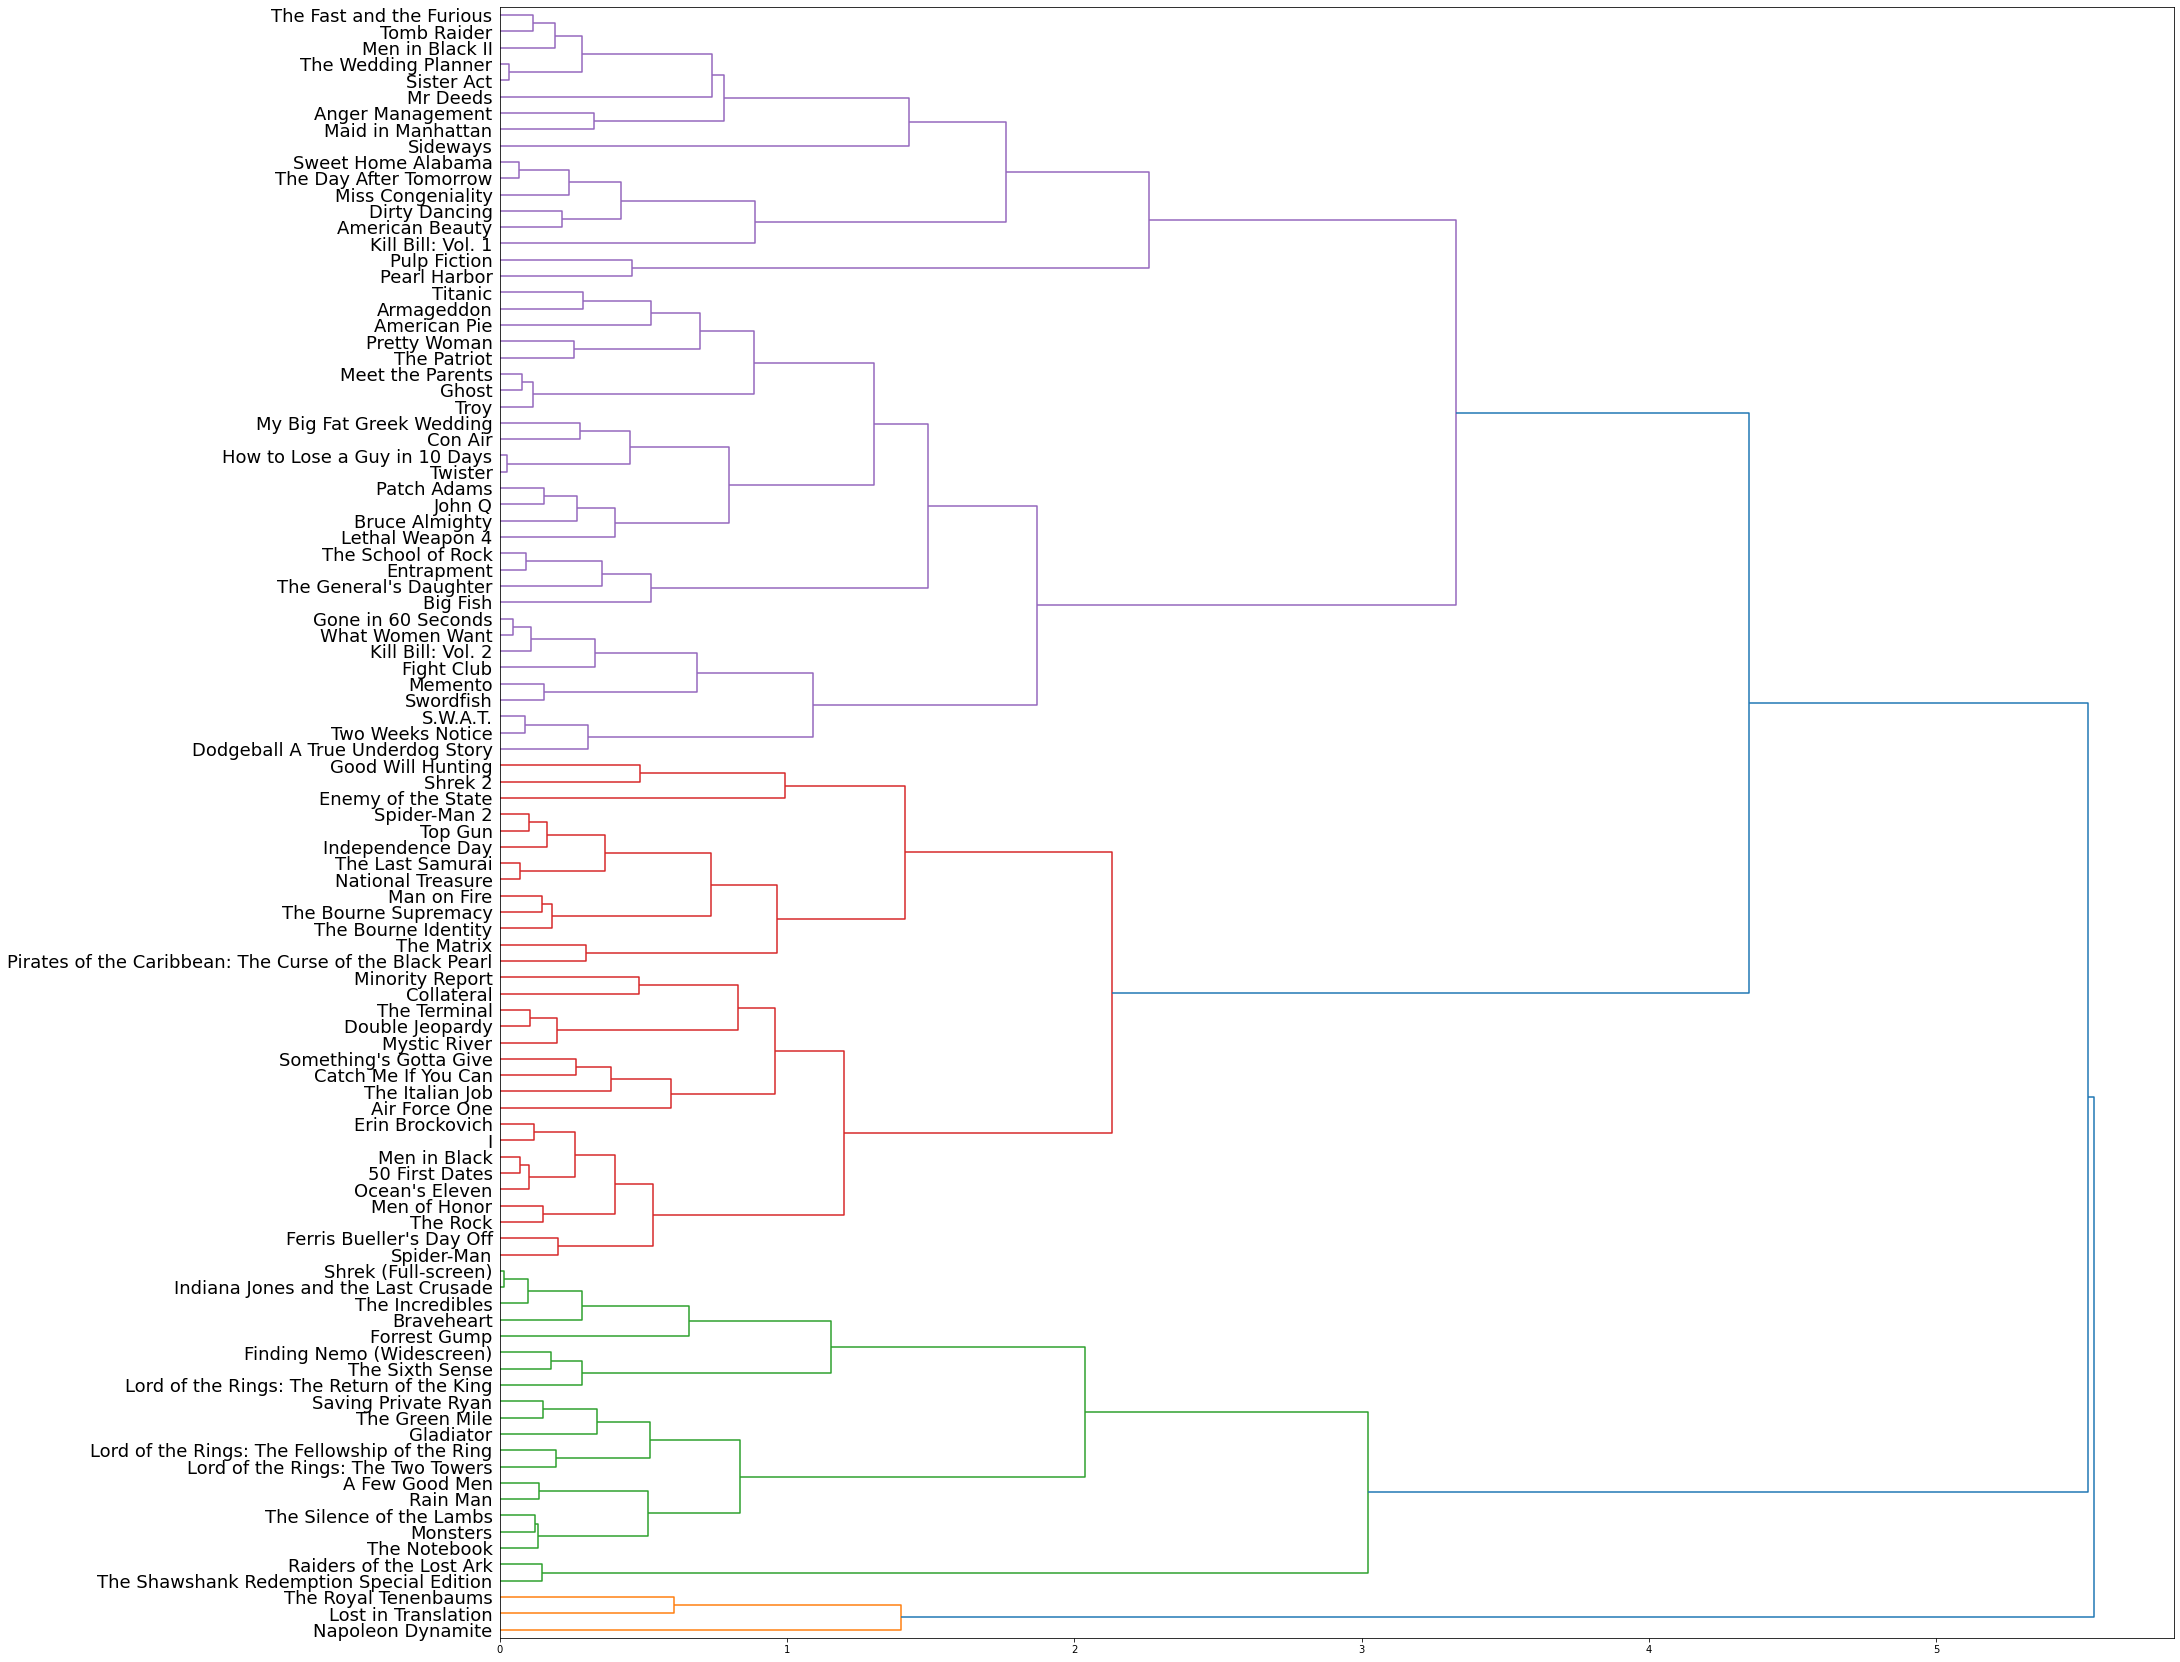

In [13]:
distance_matrix.shape
clusters = linkage(distance_matrix, 'complete')
#clusters = fcluster(c, 999, criterion='maxclust')

def leaf_label( id ):
    return film_data.columns.values[id]

fig = pylab.figure( figsize=(30,30) )
dendro = dendrogram(clusters,
                    leaf_label_func=leaf_label,
                    leaf_font_size=18,
                    leaf_rotation=0,
                    orientation="right")


By visually examining the whole dendogram, 3 or 4 clusters should provide reasonable results. Both of them are displayed below.

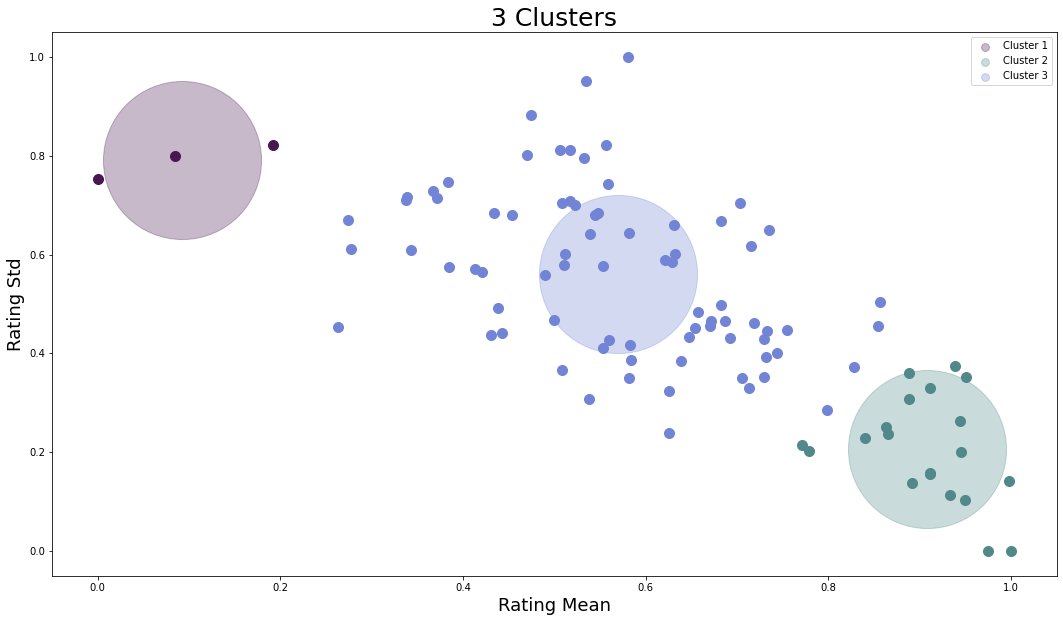

In [14]:
def plot_cluster( clust_no ):
    marker_size=100
    cluster_labels = fcluster(clusters, clust_no, criterion='maxclust')
    color_set = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(clust_no)]

    plt.figure( figsize=(18,10) )
    plt.title( str(clust_no) + " Clusters", fontsize=25 )
    plt.xlabel( "Rating Mean", fontsize=18 )
    plt.ylabel( "Rating Std", fontsize=18 )
    
    #mark individual points
    for i in range( features_scaled.shape[0] ):
        plt.scatter( features_scaled[i][0], features_scaled[i][1],c=color_set[cluster_labels[i]-1], s=marker_size)
        
    #mark cluster centers
    x_center = []
    y_center = []
    for i in range( 1,max(cluster_labels)+1 ):
        plt.scatter(
            features_scaled[ cluster_labels == i ][:,0].mean(),
            features_scaled[ cluster_labels == i ][:,1].mean(),
            alpha=0.3,
            s=250*marker_size,
            c=color_set[i-1],
            label="Cluster "+str(i)
        )
        
    plt.legend( markerscale=0.05 )
    plt.show()

plot_cluster( 3 )

Visually, most left and most rigth clusters remained intact in both configurations. Increase in clusters splitted the middle cluster into two.

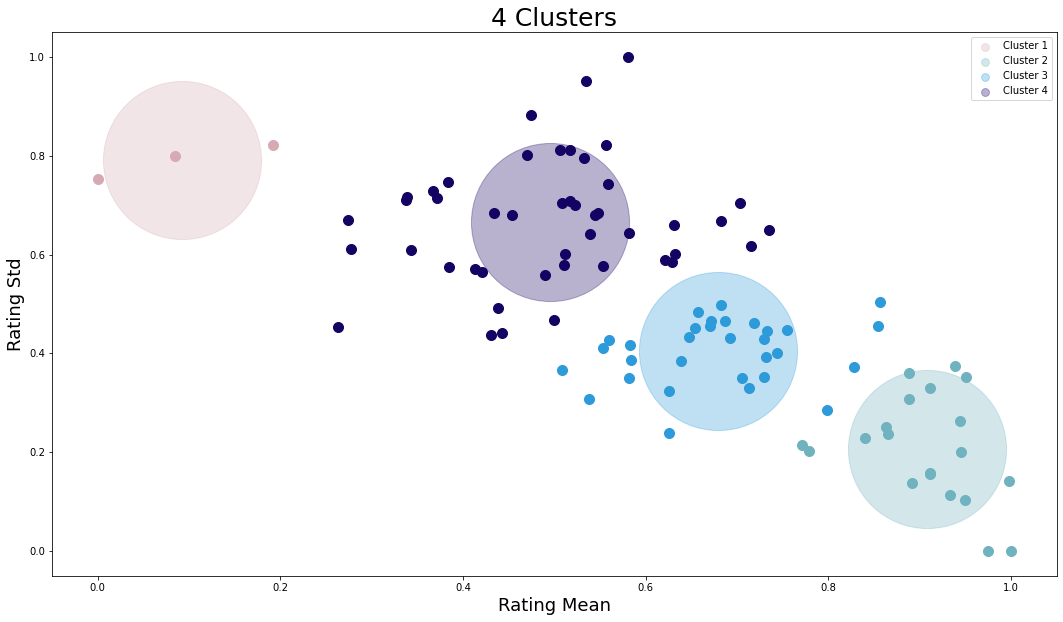

In [15]:
plot_cluster( 4 )

Respective silhouettes and scores are displayed below.

Silhouette score: 0.3538550330777037


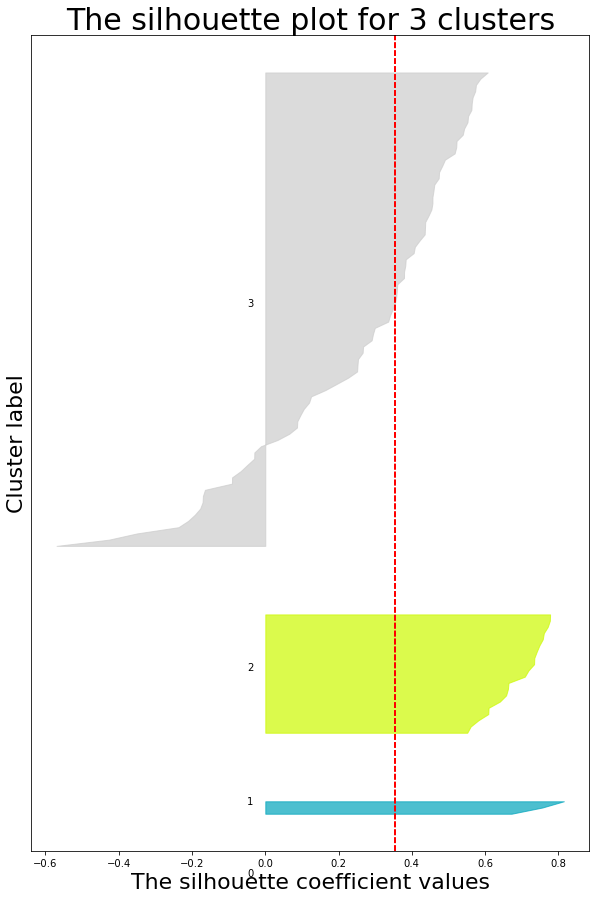

In [16]:
n_clusters = 3
cluster_labels = fcluster(clusters, n_clusters, criterion='maxclust')
sample_silhouette_values = silhouette_samples(features_scaled, cluster_labels)
silhouette_avg = silhouette_score(features_scaled, cluster_labels)

print( "Silhouette score: " + str(silhouette_avg))
fig, ax = plt.subplots()
fig.set_size_inches( 10,15 ) 


y_lower = 10 #?
for i in range( n_clusters+1 ):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for "+str(n_clusters)+" clusters", fontsize=30)
    ax.set_xlabel("The silhouette coefficient values", fontsize=22)
    ax.set_ylabel("Cluster label", fontsize=22)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks



Increase in number of clusters splitted the middle cluster and achieved a better fit. Observing silhouettes express that the split decreased the area in negative part and numerically increased average silhouette score.

Silhouette score: 0.4113763436762881


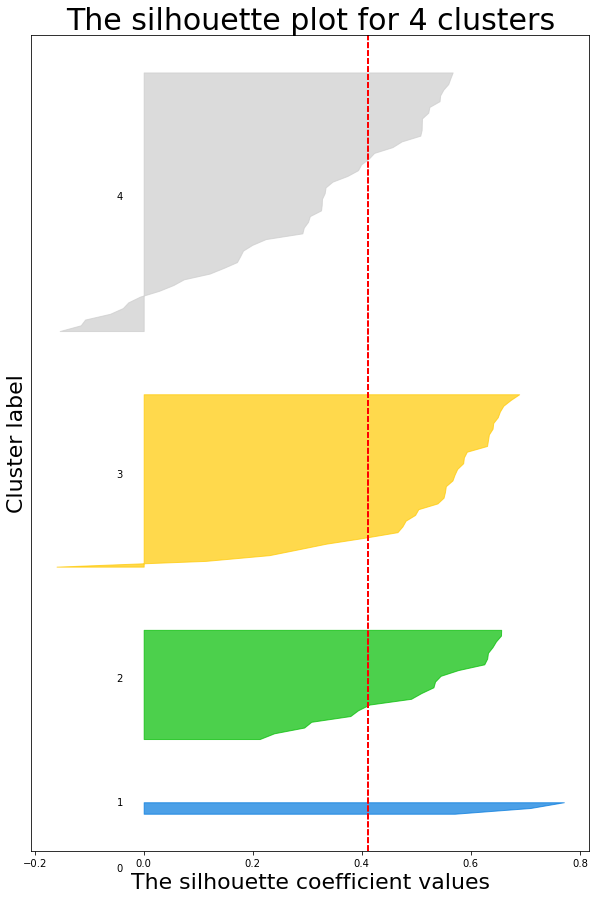

In [17]:
n_clusters = 4
cluster_labels = fcluster(clusters, n_clusters, criterion='maxclust')
sample_silhouette_values = silhouette_samples(features_scaled, cluster_labels)
silhouette_avg = silhouette_score(features_scaled, cluster_labels)

print( "Silhouette score: " + str(silhouette_avg))
fig, ax = plt.subplots()
fig.set_size_inches( 10,15 ) 


y_lower = 10 #?
for i in range( n_clusters+1 ):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for "+str(n_clusters)+" clusters", fontsize=30)
    ax.set_xlabel("The silhouette coefficient values", fontsize=22)
    ax.set_ylabel("Cluster label", fontsize=22)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks


plt.show()

In addition to silhouette score, SSE of the clusters can also be used as a performance metric. Following function calculates SSE, Inertia, of the models with given number of clusters. Changes on silhouette scores and SSE of both variables with respect to number of clusters are plotted below. The analysis is held for maximum of twenty clusters in order to obtain meaningfull results and relatively dense clusters

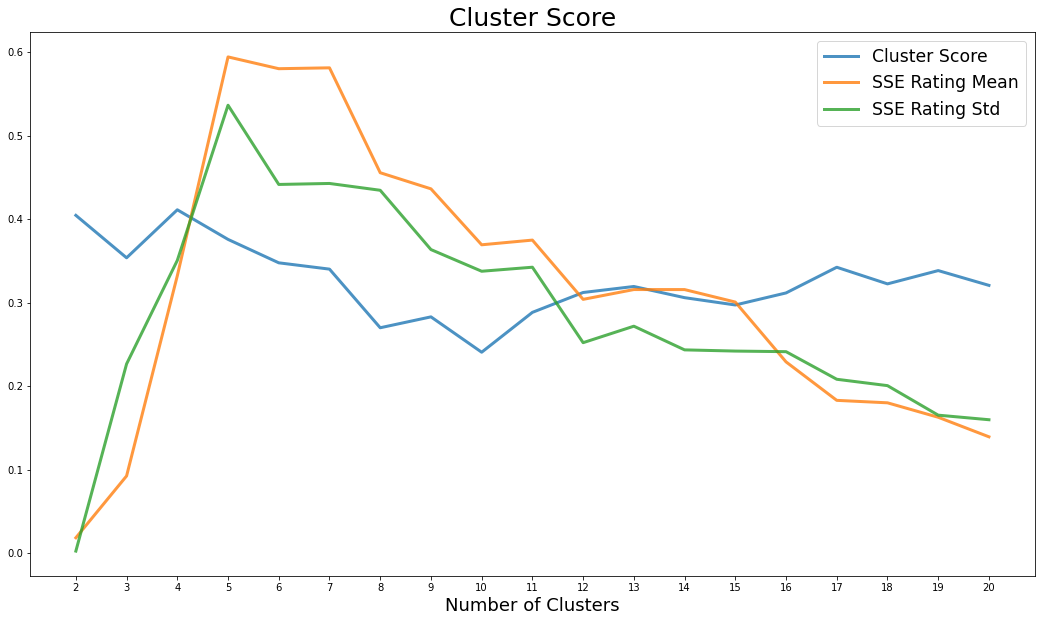

In [18]:
def cluster_sse( cluster_labels ):
    sse_rating = 0
    sse_std = 0
    for label in range( 1,max(cluster_labels) ):

        sse_rating_label = []
        sse_std_label = []
        for row in features_scaled[cluster_labels == label]:
            sse_rating_label.append( (row[0] - features_scaled[cluster_labels == label][:,0].mean())**2 )
            sse_std_label.append( (row[1] - features_scaled[cluster_labels == label][:,1].mean())**2 )

        sse_rating = sse_rating + sum( sse_rating_label )
        sse_std = sse_std + sum( sse_std_label )
    
    return( sse_rating, sse_std )


#cluster_labels
x = []
cluster_scores = []
sse_rating = []
sse_std = []
for clust_no in range(2,21):
    cluster_labels = fcluster(clusters, clust_no, criterion='maxclust')
    x.append(clust_no)
    cluster_scores.append( silhouette_score(features_scaled, cluster_labels) )
    
    sse_rating.append( cluster_sse( cluster_labels )[0] )
    sse_std.append( cluster_sse( cluster_labels )[1] )
    
    
    
plt.figure( figsize=(18,10) )
plt.title( "Cluster Score", fontsize=25 ) 
plt.xlabel( "Number of Clusters", fontsize=18 ) 
plt.plot( x, cluster_scores, label = "Cluster Score", linewidth=3, alpha=0.8 )
plt.plot( x, sse_rating, label = "SSE Rating Mean", linewidth=3, alpha=0.8 )
plt.plot( x, sse_std, label = "SSE Rating Std", linewidth=3, alpha=0.8 )
plt.xticks( x )
plt.legend( fontsize="xx-large" )
plt.show()

In order to determine the best number of clusters, gradual improvements in performance metrics are recorded and the average improvement for each increase in the number of clusters is plotted.

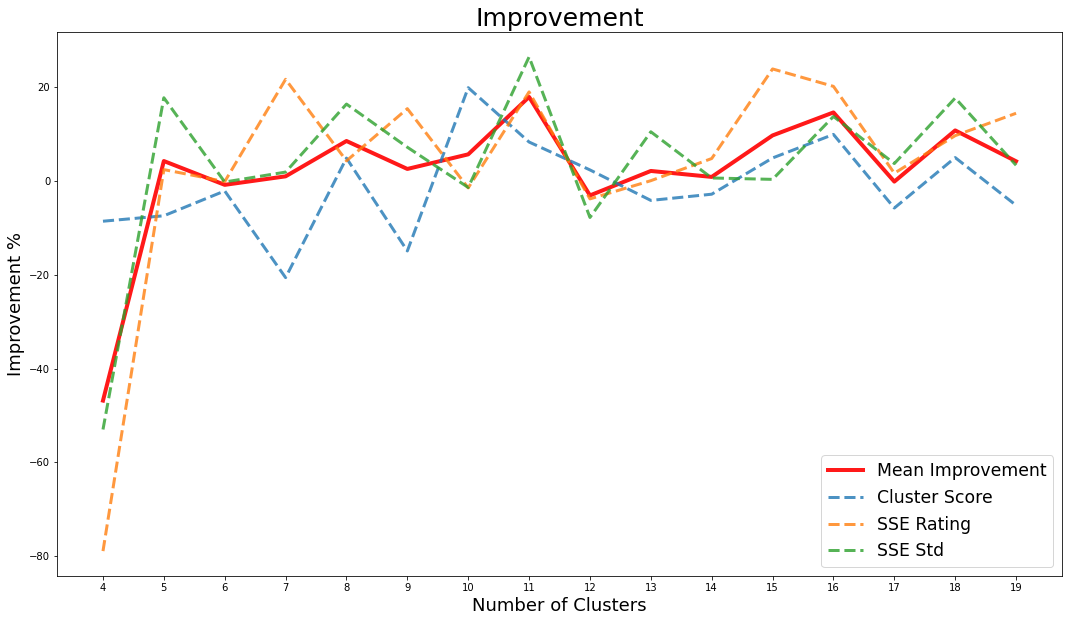

In [19]:
#-1* for sse improvements
cluster_scores_imp = []
sse_rating_imp = []
sse_std_imp = []
mean_imp = []

_from = 2
for i in range( _from, len(cluster_scores)-1 ):
    #range must be equal with the upper cell
    cluster_scores_imp.append( (cluster_scores[i+1]/cluster_scores[i]-1)*100 )
    sse_rating_imp.append( -1*(sse_rating[i+1]/sse_rating[i]-1)*100 )
    sse_std_imp.append( -1*(sse_std[i+1]/sse_std[i]-1)*100 )
    mean_imp.append( np.mean([ cluster_scores_imp[-1], sse_rating_imp[-1], sse_std_imp[-1] ]) )
    
xticks = [x+1+_from for x in np.linspace( 1, len(cluster_scores_imp), len(cluster_scores_imp) )]
plt.figure( figsize=(18,10) )
plt.plot( xticks, mean_imp, label = "Mean Improvement", linewidth=4, alpha=0.9, c="r" )
plt.plot( xticks, cluster_scores_imp, label = "Cluster Score", linewidth=3, alpha=0.8, linestyle="--" )
plt.plot( xticks, sse_rating_imp, label = "SSE Rating", linewidth=3, alpha=0.8,linestyle="--" )
plt.plot( xticks, sse_std_imp, label = "SSE Std", linewidth=3, alpha=0.8, linestyle="--" )
plt.xticks( xticks )
plt.legend( fontsize="xx-large" )
plt.title( "Improvement", fontsize=25 )
plt.xlabel( "Number of Clusters", fontsize=18 )
plt.ylabel( "Improvement %", fontsize=18 )
plt.show()

A heuristic approach of determining the number of clusters at best gradual improvement is embraced for following results.

Best improvement:  8


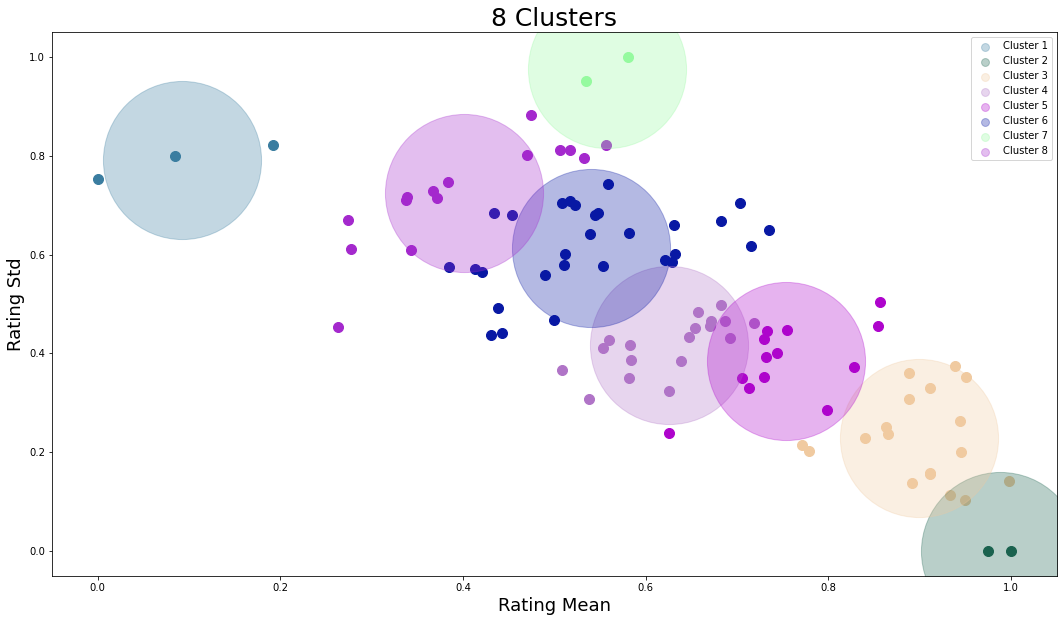

In [20]:
n_clusters = np.where(mean_imp == max( mean_imp ))[0][0] + _from -1 
print( "Best improvement: ", n_clusters  )
plot_cluster( n_clusters )

Silhouette graphs and performance metrics of eigth number of clusters are displayed below. Eigth cluster model demonstrates superiority in SSE performance measures compared to configurations with number of clusters three and four.

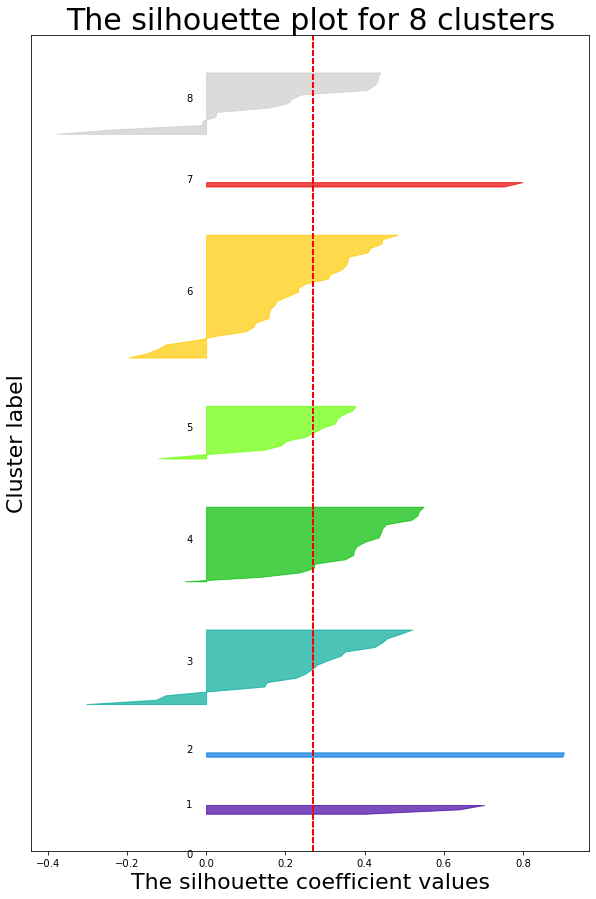

In [21]:
cluster_labels = fcluster(clusters, n_clusters, criterion='maxclust')
sample_silhouette_values = silhouette_samples(features_scaled, cluster_labels)
silhouette_avg = silhouette_score(features_scaled, cluster_labels)

#fig, (ax1, ax2) = plt.subplots(1, 2)
fig, ax = plt.subplots()
fig.set_size_inches( 10,15 ) 


y_lower = 10 #?
for i in range( n_clusters+1 ):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for "+str(n_clusters)+" clusters", fontsize=30)
    ax.set_xlabel("The silhouette coefficient values", fontsize=22)
    ax.set_ylabel("Cluster label", fontsize=22)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks


plt.show()

In [22]:
print("Silhouette score:",silhouette_avg)
print("Mean SSE:",cluster_sse( cluster_labels )[0])
print("STD SSE:",cluster_sse( cluster_labels )[1])

Silhouette score: 0.2700729569884204
Mean SSE: 0.4557778465630504
STD SSE: 0.43474551584943627


## 4. Conclusion

Visually, three or four numbers of clusters seemed to capture important properties of the data set. In comparison, four clusters covered the data better. If the aim is to progress with the least number of clusters possible, four should be choosen since it has the most cluster score. However, if the data set is going to be populated with new films, less dense clusters will not bear a problem hence number of clusters could be selected as eigth because it demonstrated superiority in terms of SSE performance measure when compared to three and four. However, four currently seems more preferable. For developing a recommendation algorithm, intrinsically films in users preference cluster should be recommended. If films that are not currently in the users preference cluster is going to be recommended to the user, cluster which is nearest to the user preference cluster should be considered, favoring the element with lowest standard deviation.